[188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875]
[188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875, 188.1875]
[188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375, 188.18359375]


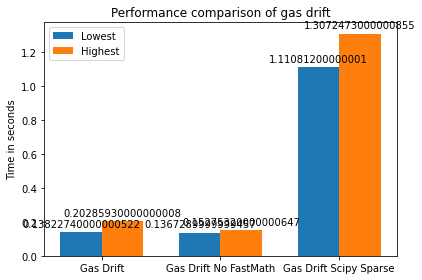

In [5]:


import timeit
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse import csc_matrix
import simulation.gas_drift as gd
from memory_profiler import memory_usage

def test_gas_drift():

        world_params = {
            'world_size': 100
        }
        world_params['carbon_dioxide_map'] = np.full(shape=(world_params['world_size'], world_params['world_size']),
                                                     fill_value=0)
        for i in range(500):
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .25)][
                int(world_params['world_size'] * .25)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .25)][
                int(world_params['world_size'] * .75)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .75)][
                int(world_params['world_size'] * .25)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .75)][
                int(world_params['world_size'] * .75)] += 1

            gd.move_gases(world_params['carbon_dioxide_map'], world_params['world_size'])

def test_gas_drift_no_fast_math():

        world_params = {
            'world_size': 100
        }
        world_params['carbon_dioxide_map'] = np.full(shape=(world_params['world_size'], world_params['world_size']),
                                                     fill_value=0)
        for i in range(500):
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .25)][
                int(world_params['world_size'] * .25)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .25)][
                int(world_params['world_size'] * .75)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .75)][
                int(world_params['world_size'] * .25)] += 1
            world_params['carbon_dioxide_map'][int(world_params['world_size'] * .75)][
                int(world_params['world_size'] * .75)] += 1

            gd.move_gases_no_fastmath(world_params['carbon_dioxide_map'], world_params['world_size'])

def test_gas_drift_scipy_sparse_matrix():
        world_params = {
            'world_size': 100
        }

        carbon_additions_each_frame = np.full(shape=(world_params['world_size'], world_params['world_size']),
                                              fill_value=0)
        carbon_additions_each_frame[int(world_params['world_size'] * .25)][int(world_params['world_size'] * .25)] += 1
        carbon_additions_each_frame[int(world_params['world_size'] * .25)][int(world_params['world_size'] * .75)] += 1
        carbon_additions_each_frame[int(world_params['world_size'] * .75)][int(world_params['world_size'] * .25)] += 1
        carbon_additions_each_frame[int(world_params['world_size'] * .75)][int(world_params['world_size'] * .75)] += 1

        world_params['carbon_dioxide_map'] = sparse.csc_matrix((world_params['world_size'], world_params['world_size']),
                                                               dtype=int)
        carbon_additions_each_frame_sparse_matrix: csc_matrix = sparse.csc_matrix(carbon_additions_each_frame)

        for i in range(500):
            world_params['carbon_dioxide_map'] = world_params['carbon_dioxide_map'] + carbon_additions_each_frame_sparse_matrix

            world_params['carbon_dioxide_map'] = gd.move_gases_scipy_sparse_matrix(world_params['carbon_dioxide_map'], world_params['world_size'])


gas_drift_time = timeit.repeat(test_gas_drift, repeat=10, number=1)
gas_drift_memory_usage = memory_usage(test_gas_drift, max_iterations=10)
print(gas_drift_memory_usage)

gas_drift_no_fastmath = timeit.repeat(test_gas_drift_no_fast_math, repeat=10, number=1)
gas_drift_no_fastmath_memory_usage = memory_usage(test_gas_drift_no_fast_math, max_iterations=10)
print(gas_drift_no_fastmath_memory_usage)

gas_drift_scipy_sparse = timeit.repeat(test_gas_drift_scipy_sparse_matrix, repeat=10, number=1)
gas_drift_scipy_sparse_memory_usage = memory_usage(test_gas_drift_scipy_sparse_matrix, max_iterations=10)
print(gas_drift_scipy_sparse_memory_usage)

# gas_drift_time.append(timeit.repeat(test_gas_drift, repeat=100, number=1))
# gas_drift__no_fastmath.append(timeit.repeat(test_gas_drift_no_fast_math, repeat=100, number=1)

labels = ['Gas Drift', 'Gas Drift No FastMath', 'Gas Drift Scipy Sparse']
lowest = [np.min(gas_drift_time), np.min(gas_drift_no_fastmath), np.min(gas_drift_scipy_sparse)]
highest = [np.max(gas_drift_time), np.max(gas_drift_no_fastmath), np.max(gas_drift_scipy_sparse)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lowest, width, label='Lowest')
rects2 = ax.bar(x + width/2, highest, width, label='Highest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time in seconds')
ax.set_title('Performance comparison of gas drift')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()